In [1]:
# Validatiion-LEAF_Toolbox-SL2P
#
# This notebook performs validation of the LEAF-Toolbox implementation of the Simplified Level 2 Prototype Processor (SL2P)
# found here https://github.com/rfernand387/LEAF-Toolbox.  This implementation corresponds to the Algorithm Theoretical Basis Document
# of Weiss and Baret (2016) and NOT the European Space Agency Biophyscial Processor which as documented bugs.  
#
# The notebook requires access to a Google Earth Engine (GEE) account.
#
# The validation relies on in-situ reference measurements acquired by Dr. Richard Fernandes of Canada Centre for Remote Sensing (CCRS)
# from both CCRS and National Ecological Observatory Network (NEON) sites and formated as GEE feature collections.
#
# The NEON data are published by the Ground Based Observation for Validtaion service (https://gbov.acri.fr/).  The CCRS data are to be published.
# (=

In [63]:
# import packages
import ee
import folium
import time
from folium import plugins
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import math 
from sklearn.linear_model import TheilSenRegressor
from numpy import nan
import scipy
import statsmodels.api as sm

In [2]:
# authenticate GEE
ee.Authenticate()

Enter verification code:  4/1ARtbsJoSXTihyoC8PNVBDv-rIVxasyGWov2PG7oTs5hFgy7R5LvovT3aJVA



Successfully saved authorization token.


In [3]:
# Authorizes the script with Earth Engine using the credentials.json file. Ensure either ee.Authenticate() has been called in a previous
# script or the "$ earthengine authenticate" command has been run in the environment to set up the credentials.json file
# The google account you provide during the authentication flow must have received access to Google Earth Engine
ee.Initialize()

In [10]:
# LEAFToolbox-SL2P
# Network for producing estimates for SL2P for S2 MSI
def s2_createFeatureCollection_estimates():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/s2_sl2p_weiss_or_prosail_NNT3_Single_0_1')


In [11]:
# LEAFToolbox-SL2P
# Network for producing standard error of estimates for SL2P for S2 MSI
def s2_createFeatureCollection_errors():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/s2_sl2p_weiss_or_prosail_NNT3_Single_0_1_error')


In [12]:
# LEAFToolbox-SL2P
# List of coded values corresponding to input domain for S2 MSI
def s2_createFeatureCollection_domains():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/S2_SL2P_WEISS_ORIGINAL_DOMAIN')

In [13]:
# LEAFToolbox-SL2P
# List of estimated values corresponding to output range for S2 MSI
def s2_createFeatureCollection_range():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/COPERNICUS_S2_SR_SL2P_RANGE')

In [14]:
# LEAFToolbox-SL2P
# Table mapping input partitions to networks for S2 MSI
def s2_createFeatureCollection_Network_Ind():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/Parameter_file_sl2p')

In [15]:
# land cover partition, we merge nalcms last so it takes precedence in a mosaic
def s2_createImageCollection_partition():
    return ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V/Global") \
             .map( lambda image: image.select("discrete_classification") \
             .remap([0,20,30,40,50,60,70,80,90,100,111,112,113,114,115,116,121,122,123,124,125,126,200],[0,8,10,15,17,16,19,18,14,13,1,3,1,5,6,6,2,4,2,5,6,6,18],0).toUint8().rename("partition")) \
             .merge(ee.ImageCollection('users/rfernand387/NA_NALCMS_2015_tiles') \
             .map(lambda image: image.select("b1").rename("partition")))

In [16]:
# LEAFToolbox-SL2P
# Mapping of input partition to networks for S2 MSI
def s2_createFeatureCollection_legend():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/Legend_sl2p')

In [17]:
def l8_createFeatureCollection_estimates():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR_SL2P_OUTPUT')

In [18]:
def l8_createFeatureCollection_errors():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR_SL2P_ERRORS')

In [19]:
def l8_createFeatureCollection_domains():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/LANDSAT_LC08_C01_T1_SR_DOMAIN')

In [20]:
def l8_createFeatureCollection_range():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/LANDSAT_LC08_C01_T1_SR_RANGE')

In [21]:
def l8_createFeatureCollection_Network_Ind():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/Parameter_file_sl2p')

In [22]:
# land cover partition, we merge nalcms last so it takes precedence in a mosaic
def l8_createImageCollection_partition():
    return ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V/Global") \
             .map( lambda image: image.select("discrete_classification") \
             .remap([0,20,30,40,50,60,70,80,90,100,111,112,113,114,115,116,121,122,123,124,125,126,200],[0,8,10,15,17,16,19,18,14,13,1,3,1,5,6,6,2,4,2,5,6,6,18],0).toUint8().rename("partition")) \
             .merge(ee.ImageCollection('users/rfernand387/NA_NALCMS_2015_tiles') \
             .map(lambda image: image.select("b1").rename("partition")))

In [23]:
def l8_createFeatureCollection_legend():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/Legend_sl2p')

In [24]:
# add a 'date' band: number of days since epoch
def addDate(image):
    return image.addBands(ee.Image.constant(ee.Date(image.date()).millis().divide(86400000)).rename('date').toUint16())

In [25]:
#computes a delta time property for an image
def deltaTime(midDate,image) :
    return ee.Image(image.set("deltaTime",ee.Number(image.date().millis()).subtract(ee.Number(midDate)).abs()))

In [26]:
# mask pixels that are not clear sky in a S2 MSI image
def s2MaskClear(image) :
    qa = image.select('QA60');
    mask = qa.bitwiseAnd(1<<10).eq(0).And(qa.bitwiseAnd(1<<11).eq(0));
    return image.updateMask(mask)

In [27]:
# add s2 geometry bands scaled by 10000
def addS2Geometry(colOptions,image) :
    return (image.addBands(image.metadata(colOptions["vza"]).multiply(3.1415).divide(180).cos().multiply(10000).toUint16().rename(['cosVZA']))
              .addBands(image.metadata(colOptions["sza"]).multiply(3.1415).divide(180).cos().multiply(10000).toUint16().rename(['cosSZA']))
              .addBands(image.metadata(colOptions["saa"]).subtract(image.metadata(colOptions["saa"])).multiply(3.1415).divide(180).cos().multiply(10000).toInt16().rename(['cosRAA'])));

In [28]:
# sentinel 2 land mask
def s2MaskLand(image) :
    #return image.updateMask(image.select('SCL').gt(0))
    return image.updateMask((image.select('SCL').eq(4)).Or(image.select('SCL').eq(5)))

In [29]:
# returns image with selected bands scaled
def scaleBands(bandList,scaleList,image) :
    bandList = ee.List(bandList)
    scaleList = ee.List(scaleList)
    return image.addBands(srcImg = image.select(bandList).multiply(ee.Image.constant(scaleList)).rename(bandList),overwrite = True)

In [30]:
# Determine if inputs fall in domain of algorithm
# Need to be updated to allow for the domain to vary with partition
def invalidInput(sl2pDomain,bandList,image) :
    
    sl2pDomain =  ee.FeatureCollection(sl2pDomain).aggregate_array("DomainCode").sort()
    bandList = ee.List(bandList).slice(3)
    image = ee.Image(image)

    # code image bands into a single band and compare to valid codes to make QC band
    image = image.addBands(image.select(bandList)
                              .multiply(ee.Image.constant(ee.Number(10)))
                              .ceil()
                              .mod(ee.Number(10))
                              .uint8()
                              .multiply(ee.Image.constant(ee.List.sequence(0,bandList.length().subtract(1)).map(lambda value: ee.Number(10).pow(ee.Number(value)))))
                              .reduce("sum")  
                              .remap(sl2pDomain, ee.List.repeat(0, sl2pDomain.length()),1)
                              .rename("QC"))
    return image




In [31]:
# returns image with single band named network id corresponding given 
def makeIndexLayer(image,legend,Network_Ind) :
    
    image = ee.Image(image)                        # partition image
    legend = ee.FeatureCollection(legend)          # legend to convert partition numbers to networks
    Network_Ind = ee.FeatureCollection(Network_Ind) # legend to convert networks to networkIDs
    
    #get lists of valid partitions
    legend_list = legend.toList(legend.size())
    landcover= legend_list.map(lambda feature: ee.Feature(feature).getNumber('Value'))

    # get corresponding networkIDs
    networkIDs = legend_list.map(lambda feature: ee.Feature(feature).get('SL2P Network')) \
                              .map(lambda propertyValue:  ee.Feature(ee.FeatureCollection(Network_Ind).first()).toDictionary().getNumber(propertyValue))
    
    return image.remap(landcover, networkIDs, 0).rename('networkID')

In [32]:
# Read coefficients of a network from csv EE asset
def getCoefs(netData,ind) :
    return((ee.Feature(netData)).getNumber(ee.String('tabledata').cat(ee.Number(ind).int().format())))

In [33]:
# Parse one row of CSV file for a network into a global variable
#
# We assume a two hidden layer network with tansig functions but
# allow for variable nodes per layer
def makeNets(feature, M) :
    
    feature = ee.List(feature);
    M = ee.Number(M);
    
    # get the requested network and initialize the created network
    netData = ee.Feature(feature.get(M.subtract(1)));
    net = {};
    
    # input slope
    num = ee.Number(6);
    start = num.add(1);
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net["inpSlope"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
    
    # input offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["inpOffset"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # hidden layer 1 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h1wt"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # hidden layer 1 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h1bi"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # hidden layer 2 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h2wt"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
  
    # hidden layer 2 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h2bi"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # output slope
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["outSlope"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
  
    # output offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["outBias"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
    
    return(ee.Dictionary(net))


In [34]:
# Parse CSV file with list of networks for a selected variable  
#This will parse one network for each landclass partition
def makeNetVars(asset, numNets, variableNum) :
    
    asset= ee.FeatureCollection(asset)
    numNets = ee.Number(numNets)
    variableNum= ee.Number(variableNum)  

    #get selected network 
    list_features = asset.flatten()
    filtered_features = ee.FeatureCollection(asset.filter(ee.Filter.eq('tabledata3', variableNum))).toList(numNets)
    
    return ee.List.sequence(1,numNets).map(lambda netNum: makeNets(filtered_features,netNum))


In [35]:
# applies two layer neural network within input and output scaling
def applyNet(outputName,netDict) :
    
    outputName = ee.String(outputName)
    netDict = ee.Dictionary(netDict)
    
    inp = ee.Image(netDict.get('Image'))
    net = ee.Dictionary(netDict.get('Network'))
    
    # Input scaling
    l1inp2D = inp.multiply(ee.Image(net.toArray(ee.List(['inpSlope']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([inp.bandNames()])) \
                   .add(ee.Image(net.toArray(ee.List(['inpOffset']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([inp.bandNames()]))
    
    # Hidden layers
    l12D = ee.Image(net.toArray(ee.List(['h1wt']),0).reshape([ee.List(net.get('h1bi')).length(),ee.List(net.get('inpOffset')).length()])) \
              .matrixMultiply(l1inp2D.toArray().toArray(1)) \
              .add(ee.Image(net.toArray(ee.List(['h1bi']),0).transpose())) \
              .arrayProject([0]).arrayFlatten([['h1w1','h1w2','h1w3','h1w4','h1w5']])
    
    # apply tansig 2/(1+exp(-2*n))-1
    l2inp2D = ee.Image(2).divide(ee.Image(1).add((ee.Image(-2).multiply(l12D)).exp())).subtract(ee.Image(1))
    
    # purlin hidden layers
    l22D = l2inp2D.multiply(ee.Image(net.toArray(ee.List(['h2wt']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2w1','h2w2','h2w3','h2w4','h2w5']])) \
                    .reduce('sum') \
                    .add(ee.Image(net.toArray(ee.List(['h2bi']),0))) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2bi']])
    
    # Output scaling 
    outputBand = l22D.subtract(ee.Image(ee.Number(net.get('outBias')))) \
                    .divide(ee.Image(ee.Number(net.get('outSlope')))) 
    
    # Return network output
    return (outputBand.rename(outputName))

In [36]:
# returns image with single band named networkid corresponding given 
# input partition image remapped to networkIDs
# applies a set of shallow networks to an image based on a provided partition image band
def wrapperNNets(network, partition, netOptions, colOptions, layerName, imageInput) :

    # typecast function parameters
    network = ee.List(network)
    partition = ee.Image(partition)
    netOptions = netOptions
    colOptions = colOptions
    layerName = layerName
    imageInput = ee.Image(imageInput)

    # parse partition  used to identify network to use
    partition = partition.clip(imageInput.geometry()).select(['partition'])
    #.remap([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,15,15,15,15],0).rename('partition')

    # determine networks based on collection
    netList = ee.List(network.get(ee.Number(netOptions.get("variable")).subtract(1))); 
    
    # parse land cover into network index and add to input image
    imageInput = imageInput.addBands(makeIndexLayer(partition,colOptions["legend"],colOptions["Network_Ind"]))

    # define list of input names
    return ee.ImageCollection(ee.List.sequence(0, netList.size().subtract(1)) \
                                                    .map(lambda netIndex: selectNet(imageInput,netList,netOptions.get("inputBands"),netIndex)) \
                                                    .map(lambda netDict: applyNet(layerName,netDict))) \
                                .max() \
                  .addBands(partition) \
                  .addBands(imageInput.select('networkID'))

In [37]:
# applies two layer neural network within input and output scaling
def applyNet2(outputName,netDict) :
    
    print("applyNet2")
    print(netDict.getInfo())
    outputName = ee.String(outputName)
    netDict = ee.Dictionary(netDict)
    inp = ee.Image(netDict.get('Image'))
    net = ee.Dictionary(netDict.get('Network'))
    print(net.getInfo())
    # Input scaling
    l1inp2D = inp.multiply(ee.Image(net.toArray(ee.List(['inpSlope']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([inp.bandNames()])) \
                   .add(ee.Image(net.toArray(ee.List(['inpOffset']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([inp.bandNames()]))

    # Hidden layers
    l12D = ee.Image(net.toArray(ee.List(['h1wt']),0).reshape([ee.List(net.get('h1bi')).length(),ee.List(net.get('inpOffset')).length()])) \
              .matrixMultiply(l1inp2D.toArray().toArray(1)) \
              .add(ee.Image(net.toArray(ee.List(['h1bi']),0).transpose())) \
              .arrayProject([0]).arrayFlatten([['h1w1','h1w2','h1w3','h1w4','h1w5']])
    
    # apply tansig 2/(1+exp(-2*n))-1
    l2inp2D = ee.Image(2).divide(ee.Image(1).add((ee.Image(-2).multiply(l12D)).exp())).subtract(ee.Image(1))
    
    # purlin hidden layers
    l22D = l2inp2D.multiply(ee.Image(net.toArray(ee.List(['h2wt']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2w1','h2w2','h2w3','h2w4','h2w5']])) \
                    .reduce('sum') \
                    .add(ee.Image(net.toArray(ee.List(['h2bi']),0))) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2bi']])
    
    # Output scaling 
    outputBand = l22D.subtract(ee.Image(ee.Number(net.get('outBias')))) \
                    .divide(ee.Image(ee.Number(net.get('outSlope')))) 

    # Return network output
    return (outputBand.rename(outputName))

In [38]:
# Read coefficients of a network from csv EE asset
def getCoefs2(netData,ind) :
    return((ee.Feature(netData)).getNumber(ee.String('tabledata').cat(ee.Number(ind).int().format())))

In [39]:
# Parse one row of CSV file for a network into a global variable
#
# We assume a two hidden layer network with tansig functions but
# allow for variable nodes per layer
def makeNets2(feature, M) :
    
    feature = ee.List(feature);
    M = ee.Number(M);
    
    # get the requested network and initialize the created network
    netData = ee.Feature(feature.get(M.subtract(1)));
    net = ee.Dictionary();
    
    # input slope
    num = ee.Number(6);
    start = num.add(1);
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("inpSlope", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))
    
    # input offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("inpOffset", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # hidden layer 1 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h1wt", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # hidden layer 1 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h1bi", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # hidden layer 2 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h2wt", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))
  
    # hidden layer 2 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h2bi", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # output slope
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("outSlope", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))
  
    # output offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("outBias", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    return(net)


In [40]:
# Parse CSV file with list of networks for a selected variable  
#This will parse one network for each landclass partition
def makeNetVars2(asset, numNets, variableNum) :
    
    print("makenetVars2")
    asset= ee.FeatureCollection(asset)
    numNets = ee.Number(numNets)
    variableNum= ee.Number(variableNum)
    

    #get selected network 
    filtered_features = ee.FeatureCollection(asset.filter(ee.Filter.eq('tabledata3', variableNum))).toList(numNets)
    
    # make only first net
    netList = makeNets2(filtered_features,1)
    return netList
    #return ee.List.sequence(1,numNets).map(lambda netNum: makeNets(filtered_features,netNum))


In [41]:
COLLECTION_OPTIONS = {
    'COPERNICUS/S2_SR': {
      "name": 'S2',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(s2_createImageCollection_partition()),
      "legend":  ee.FeatureCollection(s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    'LANDSAT/LC08/C01/T1_SR': {
      "name": 'L8',
      "description": 'LANDSAT 8',
      "Cloudcover": 'CLOUD_COVER_LAND',
      "Watercover": 'CLOUD_COVER',
      "sza": 'SOLAR_ZENITH_ANGLE',
      "vza": 'SOLAR_ZENITH_ANGLE',
      "saa": 'SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'SOLAR_AZIMUTH_ANGLE',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(l8_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(l8_createFeatureCollection_errors()),
      "sl2pDomain": ee.FeatureCollection(l8_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(l8_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(l8_createImageCollection_partition()),
      "legend":  ee.FeatureCollection(l8_createFeatureCollection_legend()),
      "numVariables": 7
    }
}
VIS_OPTIONS = {
    "Surface_Reflectance": {
        "COPERNICUS/S2_SR": {
            "Name": 'Surface_Reflectance',
            "description": 'Surface_Reflectance',
            "inp":      [ 'B4', 'B5', 'B6', 'B7', 'B8A','B9','B11','B12']
        }
      },
    "Albedo": {
        "COPERNICUS/S2_SR": {
            "Name": 'Albedo',
            "errorName": 'errorAlbedo',
            "maskName": 'maskAlbedo',
            "description": 'Black sky albedo',
            "variable": 6,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
      }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
      }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
      }  
    },
    'CCC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CCC',
            "errorName": 'errorCCC',
            "maskName": 'maskCCC',
            "description": 'Canopy chlorophyll content',
            "variable": 4,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1000]])))
      } 
    },
    'CWC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CWC',
            "errorName": 'errorCWC',
            "maskName": 'maskCWC',
            "description": 'Canopy water content',
            "variable": 5,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[100]])))
      } 
    },
    'DASF': {
        "COPERNICUS/S2_SR": {
            "Name": 'DASF',
            "errorName": 'errorDASF',
            "maskName": 'maskDASF',
            "description": 'Directional area scattering factor',
            "variable": 7,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
      } 
    }
}

In [42]:
# returns lists of sampled values for each band in an image as a new feature property
def sampleProduct(image, scaleSample, filterSize,sampleRegion, sampleName) :
    
    # cast vars
    image = ee.Image(image)
    scaleSample= ee.Number(scaleSample)
    sampleRegion = ee.Feature(sampleRegion)
    filterSize = ee.Number(filterSize)
    
    # Define a boxcar or low-pass kernel.
    boxcar = ee.Kernel.square(radius= filterSize, units= 'meters', normalize= True);

    # produce feature collection where each feature is a list of samples from a given band
    sampleData = image.convolve(boxcar).sample(region=sampleRegion.geometry(), projection=image.projection(), scale=scaleSample ,geometries=True, dropNulls = True)
    #print(sampleData)
    # for each band get a dictionary of sampled values as a property of the sampleRegion feature
    
    sampleList= ee.List(image.bandNames().map(lambda bandName: ee.Dictionary({ 'bandName': bandName, 'data': sampleData.aggregate_array(bandName)})))
    
    return sampleRegion.set(sampleName,sampleList)

In [44]:
def makeProduct(mapBounds ,colName,outputName,startDate,endDate,maxCloudcover,outputScale,outputOffset) :

    # parse the networks
    colOptions = COLLECTION_OPTIONS[colName]
    netOptions = VIS_OPTIONS[outputName][colName]
    numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
    #SL2P1 = makeNetVars2(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,1)
    SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
    errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));
    
    # make products 
    input_collection =  ee.ImageCollection(colName) \
                          .filterBounds(mapBounds) \
                          .filterDate(startDate, endDate) \
                          .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                          .limit(5000) \
                          .map(lambda image: addDate(image)) \
                          .map(lambda image: image.clip(mapBounds)) \
                          .map(lambda image: s2MaskClear(image)) \
                          .map(lambda image: addS2Geometry(colOptions,image))
    #print(input_collection.size().getInfo())

    if outputName == "Surface_Reflectance":
        products = input_collection;
    else:
        # get partition used to select network
        partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition');
        # pre process input imagery and flag invalid inputs
        input_collection  =  input_collection.map(lambda image: s2MaskLand(image)) \
                                             .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                             .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))

        ## apply networks to produce mapped parameters
        estimateSL2P = input_collection.map(lambda image: wrapperNNets(SL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"estimate"+outputName,image))
        uncertaintySL2P = input_collection.map(lambda image: wrapperNNets(errorsSL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"error"+outputName,image))
        # scale and offset mapped parameter bands
        estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
        uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
        # produce final collection
        products =  input_collection.select(['date','QC']).combine(estimateSL2P).combine(uncertaintySL2P)
        
    return products

In [46]:
# returns dictionary with image masked so the networkID band equals the netIndex and the corresponding network
def selectNet(image,netList,inputNames,netIndex) :
    
    image = ee.Image(image)
    netList = ee.List(netList)
    inputNames = ee.List(inputNames)
    netIndex = ee.Number(netIndex).int()

    return ee.Dictionary()  \
            .set("Image", ee.Image(image.updateMask(image.select('networkID').eq(netIndex)).select(inputNames))) \
            .set("Network", ee.List(netList.get(netIndex))) 

In [51]:
#makes products for specified region and time period 
def makeProductCollection(collectionName,outputName,mapBounds,startDate,endDate,maxCloudcover,outputScale,filterSize) :

    # print('makeProductCollection')
    # parse the networks
    colOptions = COLLECTION_OPTIONS[collectionName]
    netOptions = VIS_OPTIONS[outputName][collectionName]
    numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[collectionName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
    SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[collectionName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[collectionName]["Collection_SL2P"],numNets,netNum))
    errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[collectionName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[collectionName]["Collection_SL2Perrors"],numNets,netNum))

    # make products 
    input_collection =  ee.ImageCollection(collectionName) \
                      .filterBounds(mapBounds) \
                      .filterDate(startDate, endDate) \
                      .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                      .limit(5000) 
    # check if there are products
    products = []

    if (input_collection.size().getInfo() > 0):

        #add date band and clip
        input_collection = input_collection.map(lambda image: addDate(image)).map(lambda image: image.clip(mapBounds)) 
 

        if collectionName=='COPERNICUS/S2_SR':
            input_collection =  input_collection.map(lambda image: s2MaskClear(image)).map(lambda image: addS2Geometry(colOptions,image))
        elif collectionName=='LANDSAT/LC08/C01/T1_SR': 
            input_collection =  input_collection.map(lambda image: L8MaskClear(image)).map(lambda image: addL8Geometry(colOptions,image))
        elif  collectionName=='users/rfernand387/L2avalidation': 
            input_collection = input_collection.map(lambda image: ccrsSentinel2(image)).map(lambda image: s2MaskClear(image)).map(lambda image: addS2Geometry(colOptions,image))
        else:
            return

                

        # reproject to output scale based on first band
        projection = input_collection.first().select(input_collection.first().bandNames().slice(0,1)).projection()
        input_collection = input_collection.map( lambda image: image.setDefaultProjection(crs=image.select(image.bandNames().slice(0,1)).projection()).reduceResolution(reducer= ee.Reducer.mean(),maxPixels=1024).reproject(crs=projection,scale=outputScale))
                                                
        if outputName == "Surface_Reflectance":
            products = input_collection;
        else:
            # get partition used to select network
            partition = (COLLECTION_OPTIONS[collectionName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition');
            # pre process input imagery and flag invalid inputs
            input_collection  =  input_collection.map(lambda image: s2MaskLand(image)) \
                                                 .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                                 .map(lambda image: invalidInput(COLLECTION_OPTIONS[collectionName]["sl2pDomain"],netOptions["inputBands"],image))

            ## apply networks to produce mapped parameters
            estimateSL2P = input_collection.map(lambda image: wrapperNNets(SL2P,partition, netOptions, COLLECTION_OPTIONS[collectionName],"estimate",image))
            uncertaintySL2P = input_collection.map(lambda image: wrapperNNets(errorsSL2P,partition, netOptions, COLLECTION_OPTIONS[collectionName],"error",image))

            # produce final collection
            products =  input_collection.select(['date','QC']).combine(estimateSL2P).combine(uncertaintySL2P)
            
            # Define a boxcar or low-pass kernel.
            if (filterSize > 0 ):
                boxcar = ee.Kernel.square(radius= filterSize, units= 'meters', normalize= True);

                # mask by QC and boxcar filter the estimate anduncertainty layers
                smoothedData = products.map( lambda image: image.updateMask(image.select('QC').eq(0)).convolve(boxcar))
                products = products.select(['date','QC']).combine(smoothedData.select(['estimate','error']))
            


        
    return products


In [52]:
# returns lists of sampled values for each band in an image as a new feature property
def sampleProductCollection(productCollection, outputScale, sampleRegion, sampleName) :

    # print('sampleProductCollection')
    productCollection = ee.ImageCollection(productCollection)
    outputScale= ee.Number(outputScale)
    sampleRegion = ee.Feature(sampleRegion)

    # produce feature collection where each feature a feature collectiion corresponding to a list of samples from a given band from one product image
    # first add a band of ones to the image to account for masked data
    sampleData = productCollection.map(lambda image: image.sample(region=sampleRegion.geometry(), projection=image.select('date').projection(), scale=outputScale,geometries=True, dropNulls = False) ).flatten()
   
    
    # for each band get a dictionary of sampled values as a property of the sampleRegion feature
    sampleList= ee.List(productCollection.first().bandNames().map(lambda bandName: ee.Dictionary({ 'bandName': bandName, 'data': sampleData.aggregate_array(bandName)})))

    
    return sampleRegion.set(sampleName,sampleList)

In [53]:
# add dictionary of sampled values from product to a feature
def getSamples(site,outputName,collectionName,maxCloudcover,bufferSize,outputScale,deltaTime,filterSize):
    
    # print('getSamples',outputName)
    # define vars
    site = ee.Feature(site)

    
    # get start and end date for this feature
    startDate = ee.Date(site.get('system:time_start')).advance(deltaTime[0],'day')
    endDate = ee.Date(site.get('system:time_start')).advance(deltaTime[1],'day')
    
    # make collection
    sampleFeature = [];
    productCollection = []
    productCollection = makeProductCollection(collectionName,outputName,site.buffer(bufferSize*2).geometry(),startDate,endDate,maxCloudcover,outputScale,filterSize)
    if productCollection :
        if ( ee.ImageCollection(productCollection).size().gt(0) ) :
            sampleFeature = sampleProductCollection(productCollection, outputScale, site.buffer(bufferSize).geometry(),"sample" + outputName)

    return  sampleFeature

In [56]:
# make and sample products for LAI 
# features to make product over product (should be larger than plotFeatures to allow for smoothing)
collectionName = "COPERNICUS/S2_SR"
variable = "LAI"
maxCloudcover = 90
filterSize = 0 # length of square filter window applied to product
scaleSize = 20  # scale to produce and sample product
deltaTime = [-7,7] # number of days before and after sample
bufferSize = 30

# define sample records
inputList = ["projects/ccmeo-ag-000008/assets/validationGBOV/COPERNICUS_GBOV_RM7_20220616174529", \
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_HayRiverv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_Labradorv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_MerBleuv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_MtPolleyv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_PeaceRiverv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_TurkeyPointv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_VancouverIslandv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_Yellowknifev3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2020_RingOfFirev3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2021_NovaScotiav3"]
# get GEE results in python dictionary
outputDictionary = {}
for input in inputList:
    
    sampleRecords =  ee.FeatureCollection(input).filterDate('2019-01-01','2021-12-31').sort('system:time_start', False).map(lambda feature: feature.set('timeStart',feature.get('system:time_start')))
    sampleRecords =  sampleRecords.toList(sampleRecords.size())
    print(sampleRecords.size().getInfo())
    result = []
    for n in range(0,sampleRecords.size().getInfo()) : 
        print(n)
        sampleFeature= getSamples(sampleRecords.get(n),variable,collectionName,maxCloudcover,bufferSize,scaleSize,deltaTime,filterSize)
        if sampleFeature :
            result.append((ee.Dictionary(ee.Feature(sampleRecords.get(n)).toDictionary()).combine(ee.Dictionary(ee.Feature(sampleFeature).toDictionary()))).getInfo()) 
    outputDictionary.update({input: result})

LAI7dDictionary20m = outputDictionary


2625
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [57]:
# make and sample products  for fAPAR
# features to make product over product (should be larger than plotFeatures to allow for smoothing)
collectionName = "COPERNICUS/S2_SR"
variable = "fAPAR"
maxCloudcover = 90
filterSize = 0 # length of square filter window applied to product
scaleSize = 20  # scale to produce and sample product
deltaTime = [-7,7] # number of days before and after sample
bufferSize = 30

# define sample records
inputList = ["projects/ccmeo-ag-000008/assets/validationGBOV/COPERNICUS_GBOV_RM6_20220616174529", \
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_HayRiverv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_Labradorv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_MerBleuv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_MtPolleyv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_PeaceRiverv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_TurkeyPointv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_VancouverIslandv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_Yellowknifev3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2020_RingOfFirev3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2021_NovaScotiav3"]
# get GEE results in python dictionary
outputDictionary = {}
for input in inputList:
    
    sampleRecords =  ee.FeatureCollection(input).filterDate('2019-01-01','2021-12-31').sort('system:time_start', False).map(lambda feature: feature.set('timeStart',feature.get('system:time_start')))
    sampleRecords =  sampleRecords.toList(sampleRecords.size())
    
    result = []
    for n in range(0,sampleRecords.size().getInfo()) : 
        print(n)
        sampleFeature= getSamples(sampleRecords.get(n),variable,collectionName,maxCloudcover,bufferSize,scaleSize,deltaTime,filterSize)
        if sampleFeature :
            result.append((ee.Dictionary(ee.Feature(sampleRecords.get(n)).toDictionary()).combine(ee.Dictionary(ee.Feature(sampleFeature).toDictionary()))).getInfo()) 
    outputDictionary.update({input: result})

fAPAR7dDictionary20m = outputDictionary


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [58]:
# make and sample products  for fCOVER
# features to make product over product (should be larger than plotFeatures to allow for smoothing)
collectionName = "COPERNICUS/S2_SR"
variable = "fCOVER"
maxCloudcover = 90
filterSize = 0 # length of square filter window applied to product
scaleSize = 20  # scale to produce and sample product
deltaTime = [-7,7] # number of days before and after sample
bufferSize = 30


# define sample records
inputList = ["projects/ccmeo-ag-000008/assets/validationGBOV/COPERNICUS_GBOV_RM4_20220616174529", \
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_HayRiverv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_Labradorv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_MerBleuv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_MtPolleyv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_PeaceRiverv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_TurkeyPointv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_VancouverIslandv3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2019_Yellowknifev3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2020_RingOfFirev3",\
             "projects/ccmeo-ag-000008/assets/validationCCRS/CCRSInSituLAI2021_NovaScotiav3"]
# get GEE results in python dictionary
outputDictionary = {}
for input in inputList:
    
    sampleRecords =  ee.FeatureCollection(input).filterDate('2019-01-01','2021-12-31').sort('system:time_start', False).map(lambda feature: feature.set('timeStart',feature.get('system:time_start')))
    sampleRecords =  sampleRecords.toList(sampleRecords.size())
    
    result = []
    for n in range(0,sampleRecords.size().getInfo()) : 
        print(n)
        sampleFeature= getSamples(sampleRecords.get(n),variable,collectionName,maxCloudcover,bufferSize,scaleSize,deltaTime,filterSize)
        if sampleFeature :
            result.append((ee.Dictionary(ee.Feature(sampleRecords.get(n)).toDictionary()).combine(ee.Dictionary(ee.Feature(sampleFeature).toDictionary()))).getInfo()) 
    outputDictionary.update({input: result})

fCOVER7dDictionary20m = outputDictionary


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [59]:
# save sampled match ups to pickel binary files
with open("/home/richard_fernandes/validation/LAI7dDictionary0mfil20msam30mbuf.pkl", "wb") as fp:   #Pickling
    pickle.dump(LAI7dDictionary20m,fp)
with open("/home/richard_fernandes/validation/fCOVER7dDictionary0mfil20msam30mbuf.pkl", "wb") as fp:   #Pickling
    pickle.dump(fCOVER7dDictionary20m,fp)
with open("/home/richard_fernandes/validation/fAPAR7dDictionary0mfil20msam30mbuf.pkl", "wb") as fp:   #Pickling
    pickle.dump(fAPAR7dDictionary20m,fp)
    


In [73]:
# parameters for validation figures and  statistics 
sampleLAIFileName = "/home/richard_fernandes/validation/LAI7dDictionary0mfil20msam30mbuf.pkl"
samplefCOVERFileName = "/home/richard_fernandes/validation/fCOVER7dDictionary0mfil20msam30mbuf.pkl"
samplefAPARFileName = "/home/richard_fernandes/validation/fAPAR7dDictionary0mfil20msam30mbuf.pkl"

siteFileName = "/home/richard_fernandes/validation/siteSummaries.csv"
variableName = "LAI"
sites_North_America = ['Barrow','BartlettExperimentalForest','BlandyExperimentalFarm','Bondville','Boulder','CentralPlainsExperimentalRange','DeadLake','DesertRock','DesMoines','DisneyWildernessPreserve','DukeForest', \
                        'FortPeck','GoodwinCreek','GuanicaForest','HarvardForest','ImnavaitCreek','JonesEcologicalResearchCenter','Jornada','KonazPrairieBiologicalStation','LajasExperimentalStation','Manhattan','Moab', \
                       'NiwotRidgeForest','NiwotRidgeMountainResearchStation','NorthSterling','OakRidge','OnaquiAult','OrdwaySwisherBiologicalStation','RockSprings','SantaBarbara','SantaRita','SiouxFallsSurfRad',\
                       'SiousFallsUscrn','SmithsonianConservationBiologyInstitute','SmithsonianEnvironmentalResearchCenter','SouthernGreatPlains','StiegerwaldtLandServices','TableMountan',\
                       'TalladegaNationalForest','TonziRanch','Underc','WalnutGulchKendall','Williams','Woodworth','YosemiteVillage', \
                        'Geraldton2020', 'HayRiver2019' ,'Labrador2019' ,'Merbleue2019','MtPolley2019','PeaceRiver2019' ,'TurkeyPoint2019' ,'VancouverIsland2019','YellowKnife2019', 'NovaScotia2021']
treed_IGBP_class = ['Evergreen Broadleaf', 'Evergreen Needleleaf', 'Mixed Forest','Deciduous Broadleaf','Closed Shrublands','Open Shrublands']


In [74]:
# renames columns of in-situ validation samples to standard names
def renameColumns(siteDF) :
    if 'GBOV' in siteDF.name:   
        siteDF['network'] = 'GBOV'
        newNames = {'Site': 'Site', \
                        'FCOVER_down': 'fCOVER_down', \
                        'FCOVER_up': 'fCOVER_up', \
                        'FCOVER_down_err': 'fCOVER_down_err', \
                        'FCOVER_up_err': 'fCOVER_up_err', \
                        'FIPAR_down': 'fAPAR_down', \
                        'FIPAR_up': 'fAPAR_up', \
                        'FIPAR_down_err': 'fAPAR_down_err', \
                        'FIPAR_up_err': 'fAPAR_up_err', \
                        'LAI_Warren_up': 'PAI_up', \
                        'LAI_Warren_down': 'PAI_down', \
                        'LAIe_Warren_up': 'PAIe_up', \
                        'LAIe_Warren_down': 'PAIe_down', \
                        'LAIe_Miller_up': 'PAIe_Miller_up', \
                        'LAIe_Miller_down': 'PAIe_Miller_down', \
                        'LAI_Warren_up_err': 'PAI_up_err', \
                        'LAI_Warren_down_err': 'PAI_down_err', \
                        'LAIe_Warren_up_err': 'PAIe_up_err', \
                        'LAIe_Warren_down_err': 'PAIe_down_err', \
                        'LAIe_Miller_up_err': 'PAIe_Miller_up_err', \
                        'LAIe_Miller_down_err': 'PAIe_Miller_down_err'} 
    elif 'CCRS' in siteDF.name:
        list(siteDF)
        siteDF['network'] = 'CCRS'
        siteDF['IGBP_class'] = 'Mixed Forest'
        siteDF.loc[siteDF['BF']>0.75,'IGBP_class'] = 'Deciduous Broadleaf'
        siteDF.loc[siteDF['BF']<0.25,'IGBP_class'] = 'Evergreen Needleleaf'
        newNames = {'Location': 'Site', \
                    'BF' : 'fBroadleaf' , \
                    'NF': 'fNeedleafleaf' , \
                    'fcover_Down': 'fCOVER_down', \
                    'fcover_Up': 'fCOVER_up', \
                    'fcoverstd_Down': 'fCOVER_down_err', \
                    'fcoverstd_Up': 'fCOVER_up_err', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Up': 'fAPAR_up' , \
                    'Daily_Integrated_Black_Sky_fAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sky_fAPAR_Up': 'fAPAR_up' , \
                    'PAICEV61_Up': 'PAI_up', \
                    'PAICEV61_Down': 'PAI_down', \
                    'PAIeCEV61_Up': 'PAIe_up', \
                    'PAIeCEV61_Down':'PAIe_down', \
                    'PAIEMiller_Up': 'PAIe_Miller_up', \
                    'PAIEMiller_Down':'PAIe_Miller_down', \
                    'Woody_Fraction_average':'WAItoPAIratio', \
                    'Woody_Fraction_std': 'WAItoPAIratio_std' }  
    
    return  siteDF.rename(columns = newNames)

In [118]:
# defined overstory woody to total plant are ratio based on land cover 
def estimateWAItoPAIratio(samplesDF) :
    #estimate overstory woody to total area ratio for GBOV sites
    # use initial fixed ratio for all sites based on shrubs
    samplesDF.loc[(samplesDF['network'] == 'GBOV') ,'WAItoPAIratio'] = 0.10
    samplesDF.loc[(samplesDF['network'] == 'GBOV') ,'WAItoPAIratio_std'] = 0.11

    # use fixed ratio for needeleaf sites
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio_std'] = 0.10   
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio_std'] = 0.10  

    # use fixed ratio for  broadleaf sites
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio_std'] = 0.11
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio_std'] = 0.11


    # use fixed ratio for mixed forest
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio'] = 0.18
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio_std'] = 0.11

    # fix some transcription errors in WAI to PAI ratio for CCRS
    samplesDF['WAItoPAIratio'] = samplesDF['WAItoPAIratio'].clip(lower=0.1,upper=0.24)
    samplesDF['WAItoPAIratio_std'] = samplesDF['WAItoPAIratio_std'].clip(lower=0.1,upper=0.11)
    return (samplesDF)


In [119]:
# parses a file of matchups to create dataframe woth required entries for validation statistics and figures
def parseSampleFile(sampleFileName,variableName):

# clumping uncertainty
    clumping_err = 0.025
    WAItoPAIdown= 0.1
    
    with open(sampleFileName, "rb") as fp:   #Pickling
        sampleDictionary = pickle.load(fp)
    sitesList = sampleDictionary.keys()
    samplesDF = pd.DataFrame();
    
    for key in sitesList:

        #convert list to pandas data frame, rename columns, filter for North America
        siteDF = pd.concat([pd.DataFrame(sampleDictionary[key]),pd.DataFrame([key] * len(sampleDictionary[key]),columns=['geeFeatureCollection'])],axis=1)
        siteDF.name = key
        siteDF = renameColumns(siteDF)


        siteDF = siteDF[siteDF['IGBP_class'].isin(treed_IGBP_class)]
        siteDF = siteDF[siteDF['Site'].isin(sites_North_America)].reset_index()
        #number of samples and number valid samples
        numValid = []
        numSamples = []
        list(siteDF)

        for index,site in siteDF.iterrows():
            siteQC = site['sample'+variableName][1]['data']
            numSamples.append(len(siteQC))
            numValid.append(len(siteQC) - np.count_nonzero(siteQC))
        numSamplesDF= pd.DataFrame(numSamples,columns=['numSamples'])
        numValidDF = pd.DataFrame(numValid,columns=['numValid'])
        siteDF = pd.concat([siteDF,numSamplesDF, numValidDF],axis=1)
        samplesDF = pd.concat([samplesDF,siteDF],axis=0,ignore_index=True)
    
    samplesDF = samplesDF.reset_index(drop=True)
    if variableName == 'LAI' :
        
        
        samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']] = samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)

        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up'].mul(0.04830027).add(0.002163865830433743)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down'].mul(0.04830027).add(0.002163865830433743)        
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up'].mul(0.04480655).add(0.010224858872736227)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down'].mul(0.04480655).add(0.010224858872736227)

        
        samplesDF['percentValid'] = samplesDF['numValid'].div(samplesDF['numSamples'])
        
        # add error due to uncertainty in clumping
        samplesDF['PAI_up_err_clumping'] = samplesDF['PAI_up'].mul(samplesDF['PAI_up'].div((samplesDF['PAIe_up']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_up_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_up_err_clumping'].pow(2)).pow(0.5)
        samplesDF['PAI_down_err_clumping'] = samplesDF['PAI_down'].mul(samplesDF['PAI_down'].div((samplesDF['PAIe_down']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_down_err'] = samplesDF['PAI_down_err'].pow(2).add(samplesDF['PAI_down_err_clumping'].pow(2)).pow(0.5)

        #compute total canopy values including woody area
        samplesDF['PAI_total'] = samplesDF['PAI_up'].add(samplesDF['PAI_down']) 
        samplesDF['PAI_total_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_down_err'].pow(2)).pow(0.5)
        samplesDF['PAIe_total'] = samplesDF['PAIe_up'].add(samplesDF['PAIe_down']) 
        samplesDF['PAIe_total_err'] = samplesDF['PAIe_up_err'].pow(2).add(samplesDF['PAIe_down_err'].pow(2)).pow(0.5)
        samplesDF['clumping_total'] = samplesDF['PAIe_total'].div(samplesDF['PAI_total'] ) 
        samplesDF['clumping_total_err']  = (2 * clumping_err  * clumping_err) ** (0.5)          
         #compute total canopy values depending to removing woddy area
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF['LAI_up'] = samplesDF['PAI_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_up_err'] = samplesDF['PAI_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_down'] = samplesDF['PAI_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_down_err'] = samplesDF['PAI_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_total'] = samplesDF['LAI_up'] + samplesDF['LAI_down']
        samplesDF['LAI_total_err'] = samplesDF['LAI_down_err'].pow(2).add(samplesDF['LAI_up_err'].pow(2)).pow(0.5)                                                                           
        samplesDF['LAIe_up'] = samplesDF['PAIe_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_up_err'] = samplesDF['PAIe_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_down'] = samplesDF['PAIe_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_down_err'] = samplesDF['PAIe_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_total'] = samplesDF['LAIe_up'] + samplesDF['LAIe_down']
        samplesDF['LAIe_total_err'] = samplesDF['LAIe_down_err'].pow(2).add(samplesDF['LAIe_up_err'].pow(2)).add(samplesDF['LAI_up'].mul(samplesDF['LAI_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)                                                             
    elif variableName == 'fCOVER' :
        samplesDF.loc[[729],'fCOVER_down']=0
        samplesDF.loc[[730],'fCOVER_down_err']=0
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']] = samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fCOVER_up'] = samplesDF['fCOVER_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fCOVER_down'] = samplesDF['fCOVER_down'] * ( 1 - WAItoPAIdown)
        samplesDF['fCOVER_total'] = samplesDF['fCOVER_up'].add((samplesDF['fCOVER_up'].mul(-1).add(1)).mul(samplesDF['fCOVER_down'] ))
        samplesDF['fCOVER_total_err'] = samplesDF['fCOVER_down_err'].pow(2).add(samplesDF['fCOVER_up_err'].pow(2)).add(samplesDF['fCOVER_up'].mul(samplesDF['fCOVER_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    elif  variableName == 'fAPAR' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']] = samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['fAPAR_up'] = samplesDF['fAPAR_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fAPAR_down'] = samplesDF['fAPAR_down'] * ( 1 - WAItoPAIdown)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fAPAR_total'] = samplesDF['fAPAR_up'].add((samplesDF['fAPAR_up'].mul(-1).add(1)).mul(samplesDF['fAPAR_down'] ))
        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF['fAPAR_total_err'] = samplesDF['fAPAR_down_err'].pow(2).add(samplesDF['fAPAR_up_err'].pow(2)).add(samplesDF['fAPAR_up'].mul(samplesDF['fAPAR_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    else :
        print('variable not found')
              
    return(samplesDF)
                           

In [120]:
# compute residuals
def summaryStats(samplesDF,samplesLAIDF,xvariable,yvariable,trimquantile,minPAI):
    estimateMedian = [] 
    estimateSTD = [] 
    medianError = [] 
    estimateCount = [] 
    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    samplesDF = pd.concat([samplesDF.loc[samplesDF['network']=='CCRS'],samplesDF.loc[(samplesDF['PAI_total']>minPAI) & (samplesDF['network']=='GBOV')]],axis=0)
    for index, sample in samplesDF.iterrows():
        reference = sample[yvariable]
        qc = sample['sample'+xvariable][1]['data']
        estimate = sample['sample'+xvariable][2]['data']
        error = sample['sample'+xvariable][5]['data']
        productDF = pd.DataFrame(list(zip(qc,estimate,error)),columns=['qc','estimate','error'])
        productDF = productDF.loc[productDF['qc']==0]
        if productDF.shape[0]>0 :
            productDF['absresidual'] = (productDF['estimate'] - reference).abs()
            quantileResidual = productDF['absresidual'].quantile(trimquantile/100,interpolation='nearest')
            estimateMedian.append(productDF.loc[productDF['absresidual']==quantileResidual]['estimate'].mean())
            estimateSTD.append(productDF.loc[productDF['absresidual']<=quantileResidual,['estimate']].std().divide((productDF.loc[productDF['absresidual']<=quantileResidual].shape[0]) ** (0.5)))
            medianError.append(productDF.loc[productDF['absresidual']==quantileResidual]['error'].median())
            estimateCount.append(productDF.loc[productDF['absresidual']<=quantileResidual].shape[0])
        else:
            estimateMedian.append(nan)
            estimateSTD.append(nan)
            medianError.append(nan)
            estimateCount.append(0)
    samplesDF[xvariable+'_'+yvariable+'_estimate'] = estimateMedian
    samplesDF[xvariable+'_'+yvariable+'_estimate_std'] = estimateSTD 
    samplesDF[xvariable+'_'+yvariable+'_err_estimate_mean'] = medianError
    samplesDF[xvariable+'_'+yvariable+'_estimate_count'] = estimateCount
    return(samplesDF)

In [161]:
# plots accuracy precision and uncertainty curves based on residuals by fitting a polynomial of specified degree
def plotSummaryStats(x,y,err,axis,degree):

    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree = degree)
    xp = poly.fit_transform(x.reshape(-1,1))
    accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    pre = abs(y-np.array(accSummary['mean']))
    preSummary = sm.WLS(pre, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    unc = abs(y)
    # print(sm.WLS(y, xp, err ** (-2)).fit().summary())
    # print(sm.WLS(pre, xp, err ** (-2)).fit().summary())

    uncSummary = sm.WLS(unc, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    axis.plot(x, accSummary['mean'], color='darkgreen', label='Accuracy')
    axis.plot(x, accSummary['mean_ci_upper'], color='darkgreen',linewidth=0.5,linestyle='--')
    axis.plot(x, accSummary['mean_ci_lower'],color='darkgreen',linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean'], color='darkorange', label='Precision')
    axis.plot(x, preSummary['mean_ci_upper'], color='darkorange',linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean_ci_lower'],color='darkorange',linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean'], color='royalblue', label='Uncertainty')
    axis.plot(x, uncSummary['mean_ci_upper'], color='royalblue',linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean_ci_lower'],color='royalblue',linewidth=0.5,linestyle='--')
    
    return

In [122]:
# plots only uncertainty curves based on residuals by fitting a polynomial of specified degree
def plotUncertainty(x,y,err,axis,degree,color,label):

    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree = degree)
    xp = poly.fit_transform(x.reshape(-1,1))
    accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    pre = abs(y-np.array(accSummary['mean']))
    preSummary = sm.WLS(pre, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    unc = abs(y)
    uncSummary = sm.WLS(unc, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    axis.plot(x, (accSummary['mean'].pow(2).add(preSummary['mean'].pow(2)).pow(0.5)), color = color, label=label)
    axis.plot(x, uncSummary['mean_ci_upper'].sub(uncSummary['mean']).add((accSummary['mean'].pow(2).add(preSummary['mean'].pow(2)).pow(0.5))), color = color,label='+/- 95% c.i.',linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean_ci_lower'].sub(uncSummary['mean']).add((accSummary['mean'].pow(2).add(preSummary['mean'].pow(2)).pow(0.5))),color = color,linewidth=0.5,linestyle='--')


    return

In [123]:
# get summary stats after trimming quantiles of residuals to remove outliers due to poor matching
# we get stats for each quantile from 10 to 100%
samplesList = []

for p in range(10,110,10):
    print(p)
    
    samplesLAIDF = summaryStats(parseSampleFile(sampleLAIFileName,'LAI'),parseSampleFile(sampleLAIFileName,'LAI'),'LAI','PAIe_total',p,0.01).reset_index(drop=True) #.drop(['fCOVER_up','fCOVER_down','fAPAR_up','fAPAR_down','fCOVER_up_std','fCOVER_down_std','fAPAR_up_std','fAPAR_down_std'],axis=1)
    samplesfAPARDF = summaryStats(parseSampleFile(samplefAPARFileName,'fAPAR'),parseSampleFile(sampleLAIFileName,'LAI'),'fAPAR','fAPAR_total',p,0.01).reset_index(drop=True) #.drop(['fAPAR_up','fAPAR_down','fAPAR_up_std','fAPAR_down_std'],axis=1)
    samplesfCOVERDF = summaryStats(parseSampleFile(samplefCOVERFileName,'fCOVER'),parseSampleFile(sampleLAIFileName,'LAI'),'fCOVER','fCOVER_total',p,0.01).reset_index(drop=True)

    samplesDF = samplesfAPARDF[['fAPAR_up','fAPAR_down','fAPAR_total','fAPAR_up_err','fAPAR_down_err','fAPAR_total_err','samplefAPAR','fAPAR_fAPAR_total_estimate','fAPAR_fAPAR_total_estimate_std','fAPAR_fAPAR_total_err_estimate_mean','fAPAR_fAPAR_total_estimate_count']] \
                .join(samplesfCOVERDF[['fCOVER_up','fCOVER_down','fCOVER_total','fCOVER_up_err','fCOVER_down_err','fCOVER_total_err','samplefCOVER','fCOVER_fCOVER_total_estimate','fCOVER_fCOVER_total_estimate_std','fCOVER_fCOVER_total_err_estimate_mean','fCOVER_fCOVER_total_estimate_count']])
    

    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    
    samplesDF = samplesDF[samplesDF['LAI_PAIe_total_estimate_count']>0]
    samplesDF = samplesDF.dropna(subset='fAPAR_fAPAR_total_estimate')
    samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total_err'].mul(0.5) \
                                    .add(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total_err'].mul(0.5) \
                                    .add(samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total_err'].mul(0.5) \
                                    .add(samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    samplesDF = samplesDF.drop(samplesDF[samplesDF['Elevation'] > 3000].index)

    
    samplesList.append(samplesDF)



10
20
30
40
50
60
70
80
90
100


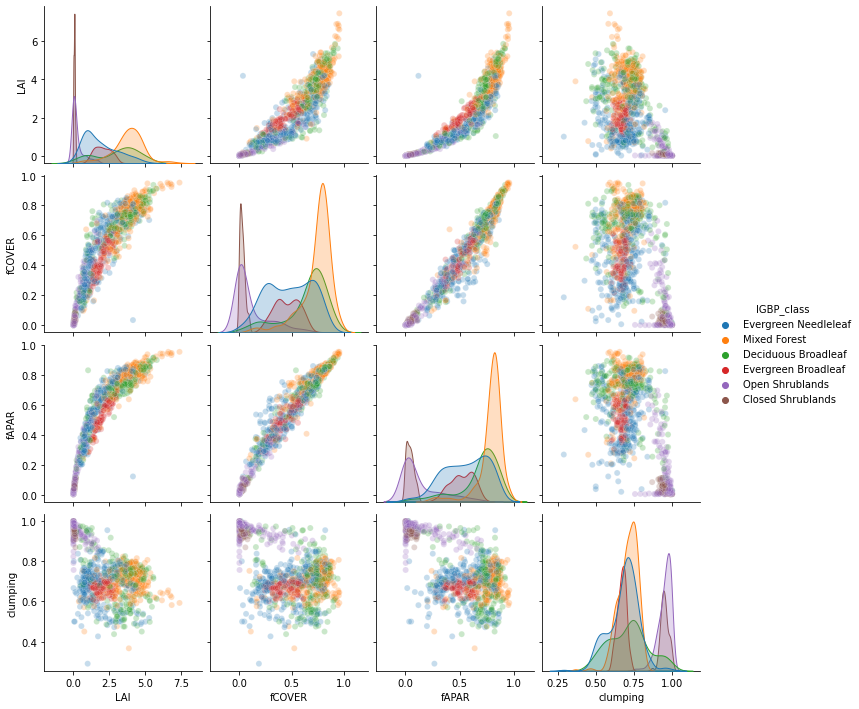

In [131]:
# figure 5a  reference variables by IGBP
samplesDF = samplesList[4].rename(columns={'LAI_total':'LAI','fCOVER_total':'fCOVER','fAPAR_total':'fAPAR','clumping_total':'clumping',})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping','IGBP_class']]
g = sns.pairplot(samplesDFfig1, hue='IGBP_class', markers= 'o',plot_kws={'alpha': 0.25})
plt.savefig('figure5a.png') 

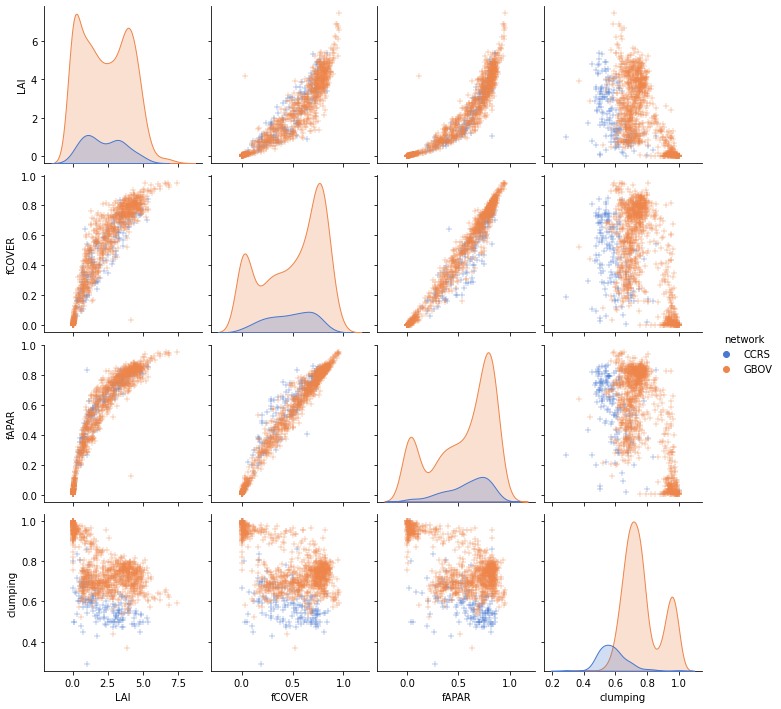

In [148]:
# figure 5b  reference variables by network
samplesDF = samplesList[4].rename(columns={'LAI_total':'LAI','fCOVER_total':'fCOVER','fAPAR_total':'fAPAR','clumping_total':'clumping',})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping','network']]
g = sns.pairplot(samplesDFfig1, hue='network', markers= '+',plot_kws={'alpha': 0.75},palette='muted')
plt.savefig('Figure5b.png')

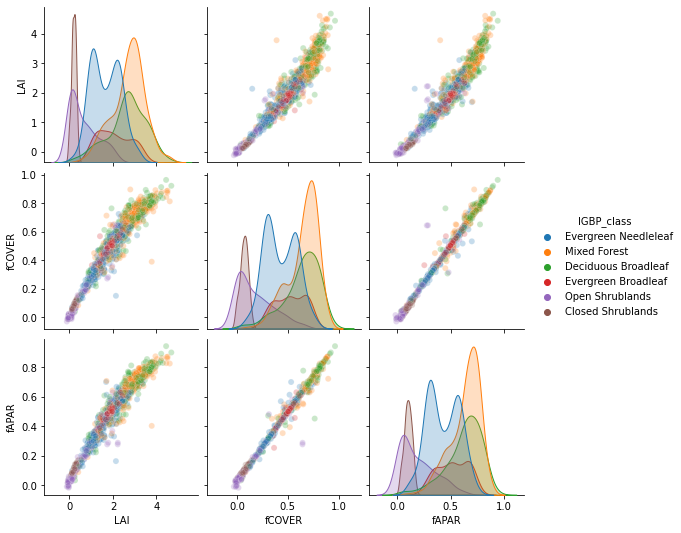

In [146]:
# figure 6a sl2p variables by IGBP
samplesDF = samplesList[4].rename(columns={'LAI_PAIe_total_estimate':'LAI','fCOVER_fCOVER_total_estimate':'fCOVER','fAPAR_fAPAR_total_estimate':'fAPAR'})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','IGBP_class']]
g = sns.pairplot(samplesDFfig1, hue='IGBP_class', markers= 'o',plot_kws={'alpha': 0.25})
plt.savefig('Figure6a.png')

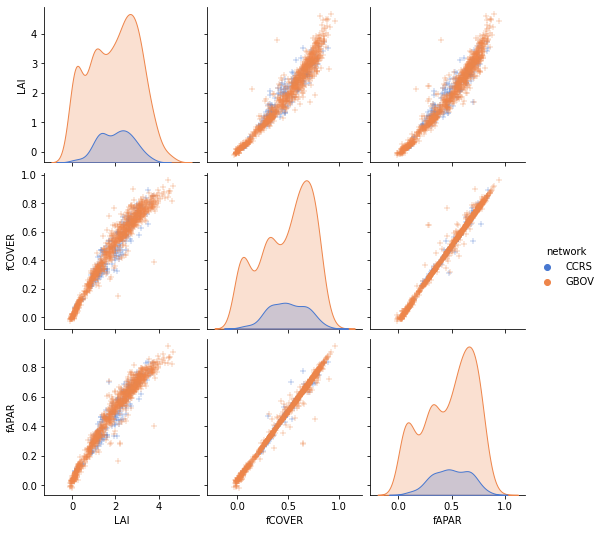

In [147]:
# figure 6b sl2p variables by network
samplesDF = samplesList[4].rename(columns={'LAI_PAIe_total_estimate':'LAI','fCOVER_fCOVER_total_estimate':'fCOVER','fAPAR_fAPAR_total_estimate':'fAPAR',})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','network']]
g = sns.pairplot(samplesDFfig1, hue='network', markers= '+',plot_kws={'alpha': 0.75},palette='muted')
plt.savefig('Figure6b.png')

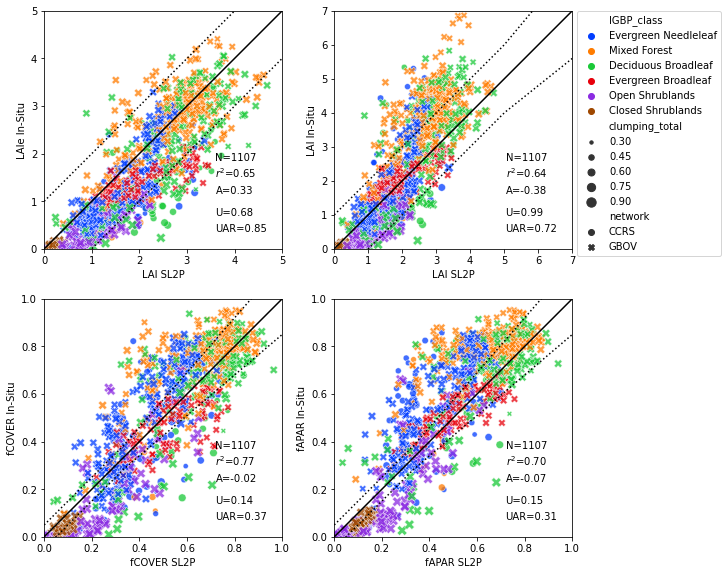

In [167]:
# figure 7

fig, ax = plt.subplots(2,2,constrained_layout = True)
fig.set_size_inches(10 ,8)
data = samplesList[4]


y = data['LAIe_total']
yerror = data['LAIe_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = data['LAI_PAIe_total_err_estimate_mean'].astype('float')
# ax[0,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAIe_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=0.75,palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.maximum(np.linspace(0,6,100)*0.20,1),color='black',linestyle='dotted')
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.minimum(-np.linspace(0,6,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,0].plot([0,6],[0,6],color='black')
ax[0,0].set(adjustable='box',aspect='equal')
ax[0,0].set_ylabel('LAIe In-Situ')
ax[0,0].set_xlabel('LAI SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(1,0.2*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[0,0].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[0,0].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[0,0].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[0,0].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[0,0].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['LAI_total']
yerror = data['LAI_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = data['LAI_PAIe_total_err_estimate_mean'].astype('float')
# ax[0,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[0,1])
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.maximum(np.linspace(0,7,100)*0.20,1),color='black',linestyle='dotted')
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.minimum(-np.linspace(0,7,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,1].plot([0,7],[0,7],color='black')
ax[0,1].set(adjustable='box',aspect='equal')
ax[0,1].set_ylabel('LAI In-Situ')
ax[0,1].set_xlabel('LAI SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(1,0.2*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[0,1].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[0,1].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[0,1].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[0,1].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[0,1].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['fCOVER_total']
yerror = data['fCOVER_total_err']
x = data['fCOVER_fCOVER_total_estimate']
xerror = data['fCOVER_fCOVER_total_err_estimate_mean'].astype('float')
# ax[1,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.scatterplot(data=data, x='fCOVER_fCOVER_total_estimate', y='fCOVER_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,0].plot([0,1],[0,1],color='black')
ax[1,0].set(adjustable='box',aspect='equal')
ax[1,0].set_ylabel('fCOVER In-Situ')
ax[1,0].set_xlabel('fCOVER SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(0.05,0.10*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[1,0].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[1,0].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[1,0].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[1,0].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[1,0].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['fAPAR_total']
yerror = data['fAPAR_total_err']
x = data['fAPAR_fAPAR_total_estimate']
xerror = data['fAPAR_fAPAR_total_err_estimate_mean'].astype('float')
# ax[1,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='fAPAR_fAPAR_total_estimate', y='fAPAR_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,1].plot([0,1],[0,1],color='black')
ax[1,1].set(adjustable='box',aspect='equal')
ax[1,1].set_ylabel('fAPAR In-Situ')
ax[1,1].set_xlabel('fAPAR SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(0.05,0.10*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[1,1].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[1,1].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[1,1].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[1,1].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[1,1].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

ax[0,0].set_xlim([0,5])
ax[0,1].set_xlim([0,7])
ax[1,0].set_xlim([0,1])
ax[1,1].set_xlim([0,1])
ax[0,0].set_ylim([0,5])
ax[0,1].set_ylim([0,7])
ax[1,0].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
plt.savefig('Figure7Brown.png',bbox_inches='tight')
plt.show()


Series([], Name: WAItoPAIratio_std, dtype: float64)


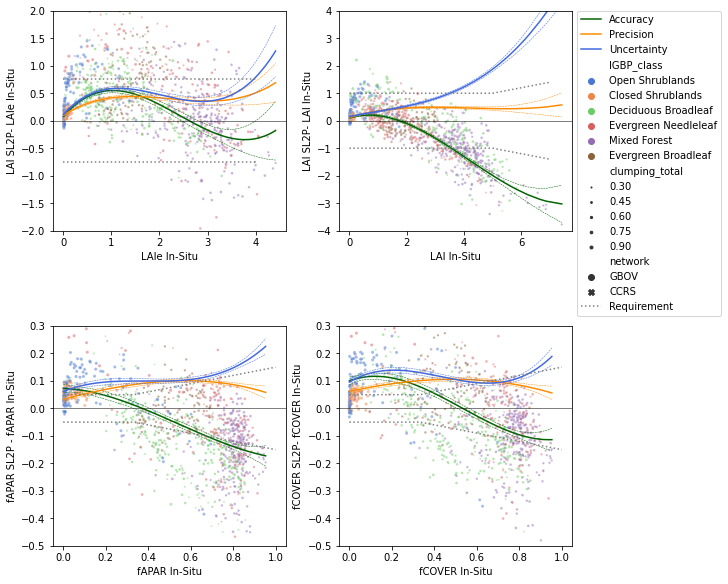

In [165]:
# figure 8


fig, ax = plt.subplots(2, 2,constrained_layout = True)
fig.set_size_inches(10, 8)

percentileToPlot = 4

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[0,0],3)
sns.scatterplot(data=data, x='LAIe_total', y='LAIe_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,4,100),np.maximum(np.linspace(0,4,100)*0.2*0.75,1*0.75),color='grey',linestyle='dotted')
ax[0,0].plot(np.linspace(0,4,100),np.minimum(-np.linspace(0,4,100)*0.2*0.75,-1*0.75),color='grey',linestyle='dotted')
ax[0,0].axhline(y=0,color='black',linewidth=0.5)
ax[0,0].set_ylim([-2,2])
ax[0,0].set_ylabel('LAI SL2P- LAIe In-Situ')
ax[0,0].set_xlabel('LAIe In-Situ')
uarLAIemid = np.sum(np.abs(y)<np.maximum(x*0.15,.5))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[0,1],3)
sns.scatterplot(data=data, x='LAI_total', y='LAI_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,1],legend=True)
ax[0,1].plot(np.linspace(0,7,100),np.maximum(np.linspace(0,7,100)*0.2,1),color='grey',linestyle='dotted',label='Requirement')
ax[0,1].plot(np.linspace(0,7,100),np.minimum(-np.linspace(0,7,100)*0.2,-1),color='grey',linestyle='dotted')
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax[0,1].axhline(y=0,color='black',linewidth=0.5)
ax[0,1].set_ylim([-4,4])
ax[0,1].set_ylabel('LAI SL2P- LAI In-Situ')
ax[0,1].set_xlabel('LAI In-Situ')
uarLAImid = np.sum(np.abs(y)<np.maximum(x*0.15,.5))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
print(data[data['fAPAR_total_err'].isnull()]['WAItoPAIratio_std'])
plotSummaryStats(x,y,err,ax[1,0],3)
sns.scatterplot(data=data, x='fAPAR_total', y='fAPAR_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,0].axhline(y=0,color='black',linewidth=0.5)
ax[1,0].set_ylim([-0.5,0.3])
ax[1,0].set_ylabel('fAPAR SL2P - fAPAR In-Situ')
ax[1,0].set_xlabel('fAPAR In-Situ')
uarfAPARmid = np.sum(np.abs(y)<np.maximum(x*0.10,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[1,1],3)

sns.scatterplot(data=data, x='fCOVER_total', y='fCOVER_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,1].axhline(y=0,color='black',linewidth=0.5)
ax[1,1].set_ylim([-0.5,0.3])
ax[1,1].set_ylabel('fCOVER SL2P- fCOVER In-Situ')
ax[1,1].set_xlabel('fCOVER In-Situ')
uarfCOVERmid = np.sum(np.abs(y)<np.maximum(x*0.10,0.05))/y.size
plt.savefig('Figure8.png',bbox_inches='tight')

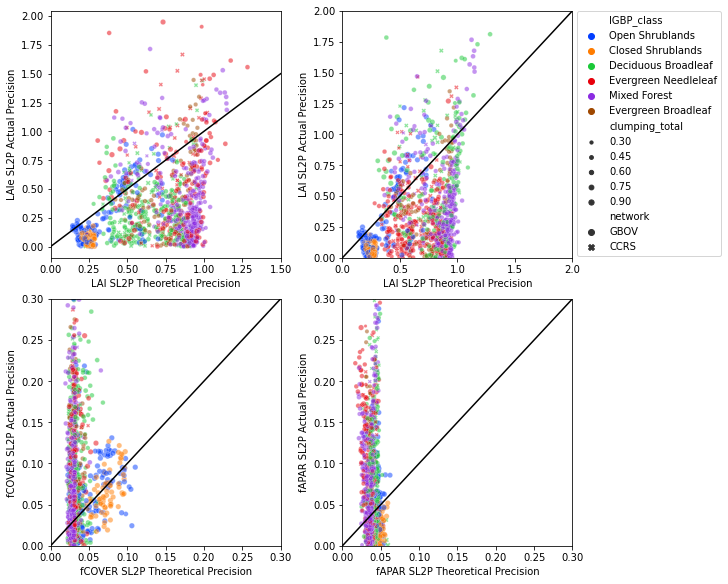

In [151]:
# figure 9
import numpy.polynomial.chebyshev as cheb
fig, ax = plt.subplots(2, 2,constrained_layout = True)
fig.set_size_inches(10, 8)

percentileToPlot = 4
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 3)

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
xp = poly.fit_transform(x.reshape(-1,1))
accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
pre = abs(y-np.array(accSummary['mean']))

    
data['LAIe_precision'] = pre
sns.scatterplot(data=data, x='LAI_PAIe_total_err_estimate_mean', y='LAIe_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 30), alpha=.5, palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,1.5,100),np.linspace(0,1.5,100),color='black')
ax[0,1].set_ylim([0,1.5])
ax[0,0].set_xlim([0,1.5])
ax[0,0].set_ylabel('LAIe SL2P Actual Precision')
ax[0,0].set_xlabel('LAI SL2P Theoretical Precision')


#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
xp = poly.fit_transform(x.reshape(-1,1))
accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
pre = abs(y-np.array(accSummary['mean']))

data['LAI_precision'] = pre
sns.scatterplot(data=data, x='LAI_PAIe_total_err_estimate_mean', y='LAI_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 30), alpha=.5, palette="bright", ax=ax[0,1],legend=True)
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax[0,1].plot(np.linspace(0,2,100),np.linspace(0,2,100),color='black')
ax[0,1].set_ylim([0,2])
ax[0,1].set_xlim([0,2])
ax[0,1].set_ylabel('LAI SL2P Actual Precision')
ax[0,1].set_xlabel('LAI SL2P Theoretical Precision')


#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
xp = poly.fit_transform(x.reshape(-1,1))
accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
pre = abs(y-np.array(accSummary['mean']))

data['fCOVER_precision']=pre
sns.scatterplot(data=data, x='fCOVER_fCOVER_total_err_estimate_mean', y='fCOVER_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 30), alpha=.5, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,.3,100),np.linspace(0,.3,100),color='black')
ax[1,0].set_ylim([0,.3])
ax[1,0].set_xlim([0,.3])
ax[1,0].set_ylabel('fCOVER SL2P Actual Precision')
ax[1,0].set_xlabel('fCOVER SL2P Theoretical Precision')
#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
xp = poly.fit_transform(x.reshape(-1,1))
accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
pre = abs(y-np.array(accSummary['mean']))

data['fAPAR_precision'] = pre
sns.scatterplot(data=data, x='fAPAR_fAPAR_total_err_estimate_mean', y='fAPAR_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(5,30), alpha=.5, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,.3,100),np.linspace(0,.3,100),color='black')
ax[1,1].set_ylim([0,.3])
ax[1,1].set_xlim([0,.3])
ax[1,1].set_ylabel('fAPAR SL2P Actual Precision')
ax[1,1].set_xlabel('fAPAR SL2P Theoretical Precision')
plt.savefig('Figure9.png',bbox_inches='tight')


0       0.512200
1       0.479939
2       0.483382
3       0.507162
4       0.545346
          ...   
1328    0.423090
1329    0.870925
1330    0.770233
1331    0.825797
1332    0.451470
Name: LAI_PAIe_total_err_estimate_mean, Length: 1107, dtype: float64


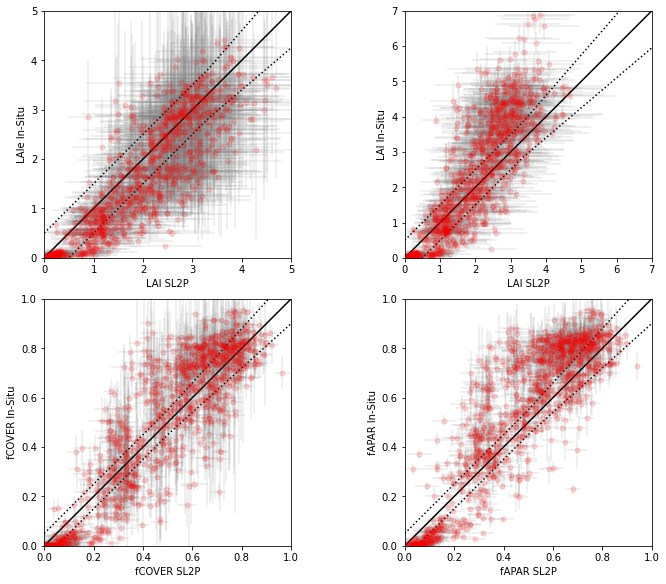

In [152]:
# figure 6

fig, ax = plt.subplots(2,2,constrained_layout = True)
fig.set_size_inches(10 ,8)
data = samplesList[4]

print(data['LAI_PAIe_total_err_estimate_mean'])
y = data['LAIe_total']
yerror = data['LAIe_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = ((data['LAI_PAIe_total_estimate_std'].astype('float')).pow(2).add(data['LAI_PAIe_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[0,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.15)
#sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAIe_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=0.75,palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.maximum(np.linspace(0,6,100)*0.15,0.5),color='black',linestyle='dotted')
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.minimum(-np.linspace(0,6,100)*0.15,-0.5),color='black',linestyle='dotted')
ax[0,0].plot([0,6],[0,6],color='black')
ax[0,0].set(adjustable='box',aspect='equal')
ax[0,0].set_ylabel('LAIe In-Situ')
ax[0,0].set_xlabel('LAI SL2P')


y = data['LAI_total']
yerror = data['LAI_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = ((data['LAI_PAIe_total_estimate_std'].astype('float')).pow(2).add(data['LAI_PAIe_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[0,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.15)
#sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[0,1])
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.maximum(np.linspace(0,7,100)*0.15,0.5),color='black',linestyle='dotted')
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.minimum(-np.linspace(0,7,100)*0.15,-0.5),color='black',linestyle='dotted')
ax[0,1].plot([0,7],[0,7],color='black')
ax[0,1].set(adjustable='box',aspect='equal')
ax[0,1].set_ylabel('LAI In-Situ')
ax[0,1].set_xlabel('LAI SL2P')

y = data['fCOVER_total']
yerror = data['fCOVER_total_err']
x = data['fCOVER_fCOVER_total_estimate']
xerror = ((data['fCOVER_fCOVER_total_estimate_std'].astype('float')).pow(2).add(data['fCOVER_fCOVER_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[1,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.15)
# ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#sns.scatterplot(data=data, x='fCOVER_fCOVER_total_estimate', y='fCOVER_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.1,0.05),color='black',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.1,-0.05),color='black',linestyle='dotted')
ax[1,0].plot([0,1],[0,1],color='black')
ax[1,0].set(adjustable='box',aspect='equal')
ax[1,0].set_ylabel('fCOVER In-Situ')
ax[1,0].set_xlabel('fCOVER SL2P')

y = data['fAPAR_total']
yerror = data['fAPAR_total_err']
x = data['fAPAR_fAPAR_total_estimate']
xerror = ((data['fAPAR_fAPAR_total_estimate_std'].astype('float')).pow(2).add(data['fAPAR_fAPAR_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[1,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.15)
#sns.scatterplot(data=data, x='fAPAR_fAPAR_total_estimate', y='fAPAR_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.1,0.05),color='black',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.1,-0.05),color='black',linestyle='dotted')
ax[1,1].plot([0,1],[0,1],color='black')
ax[1,1].set(adjustable='box',aspect='equal')
ax[1,1].set_ylabel('fAPAR In-Situ')
ax[1,1].set_xlabel('fAPAR SL2P')

ax[0,0].set_xlim([0,5])
ax[0,1].set_xlim([0,7])
ax[1,0].set_xlim([0,1])
ax[1,1].set_xlim([0,1])
ax[0,0].set_ylim([0,5])
ax[0,1].set_ylim([0,7])
ax[1,0].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
plt.savefig('FigureS1.png',bbox_inches='tight')
plt.show()

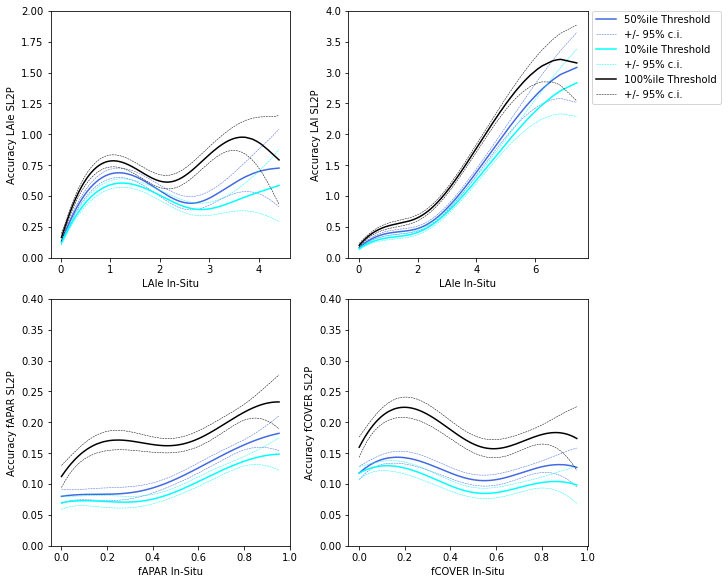

In [154]:
# figure S2


fig, ax = plt.subplots(2, 2,constrained_layout = True)
fig.set_size_inches(10, 8)

percentileToPlot = 4

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,0],3,'royalblue','50%ile Threshold')
uarLAIelow= np.sum(np.abs(y)<np.maximum(x*0.15,0.5))/y.size
ax[0,0].set_ylim([0,2])
ax[0,0].set_ylabel('Accuracy LAIe SL2P')
ax[0,0].set_xlabel('LAIe In-Situ')

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,1],3,'royalblue','50%ile Threshold')
uarLAIlow = np.sum(np.abs(y)<np.maximum(x*0.15,0.5))/y.size
ax[0,1].set_ylim([0,4])
ax[0,1].set_ylabel('Accuracy LAI SL2P')
ax[0,1].set_xlabel('LAIe In-Situ')


#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])
data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])
y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,0],3,'royalblue','50%ile Threshold')
uarfAPARlow = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size
ax[1,0].set_ylim([0,.4])
ax[1,0].set_ylabel('Accuracy fAPAR SL2P')
ax[1,0].set_xlabel('fAPAR In-Situ')

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,1],3,'royalblue','50%ile Threshold')
ax[1,1].set_ylim([0,.4])
ax[1,1].set_ylabel('Accuracy fCOVER SL2P')
ax[1,1].set_xlabel('fCOVER In-Situ')


percentileToPlot = 1

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,0],3,'aqua','10%ile Threshold')
uarLAIelow= np.sum(np.abs(y)<np.maximum(x*0.15,.5))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,1],3,'aqua','10%ile Threshold')
uarLAIlow = np.sum(np.abs(y)<np.maximum(x*0.15,.5))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])
data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])
y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,0],3,'aqua','10%ile Threshold')
uarfAPARlow = np.sum(np.abs(y)<np.maximum(x*0.1,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,1],3,'aqua','10%ile Threshold')

percentileToPlot = 9

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,0],3,'black','100%ile Threshold')
uarLAIehigh= np.sum(np.abs(y)<np.maximum(x*0.15,.5))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,1],3,'black','100%ile Threshold')
uarLAIhigh = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])
data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,0],3,'black','100%ile Threshold')
uarfAPARhigh = np.sum(np.abs(y)<np.maximum(x*0.1,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,1],3,'black','100%ile Threshold')
uarfCOVERhigh = np.sum(np.abs(y)<np.maximum(x*0.1,0.05))/y.size




ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('FigureS2.png',bbox_inches='tight')
plt.show()
